In [1]:
# %%
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.visuals import *
import pickle

# ***** Define stellar properties *****#
R_s = 1.21 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56  # Stellar log surface gravity (log10(cm/s^2) by convention)
# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 1.21 * R_J  # Planetary radius (m)
M_p = 0.07 * M_J  # Mass of planet (kg)
g_p = 4.3712  # Gravitational field of planet (m/s^2)
T_eq = 1043.8  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

from POSEIDON.core import define_model

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["Fe", "Cr", "Mg"]  # H2O, CO as in Brogi & Line

method = "sysrem"
# high_res_params = ['a', 'b', 'dPhi', 'K_p', 'V_sys', 'W_conv']
high_res_params = ["K_p", "V_sys", "W_conv", "log_alpha"]

model_1 = define_model(
    "Fe Cr Mg Madhu Injection",
    bulk_species,
    param_species,
    PT_profile="isotherm",
    cloud_model="MacMad17",
    cloud_type="deck",
    high_res_params=high_res_params,
    reference_parameter="R_p_ref",
)


model_2 = define_model(
    "Fe Cr Mg Madhu Injection Madhu",
    bulk_species,
    param_species,
    PT_profile="Madhu",
    cloud_model="MacMad17",
    cloud_type="deck",
    high_res_params=high_res_params,
    reference_parameter="R_p_ref",
)

/home/rwang/miniconda3/envs/poseidon/lib/python3.9/site-packages/POSEIDON/absorption.py:1466: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


Generating corner plot 0...
Generating corner plot 1...


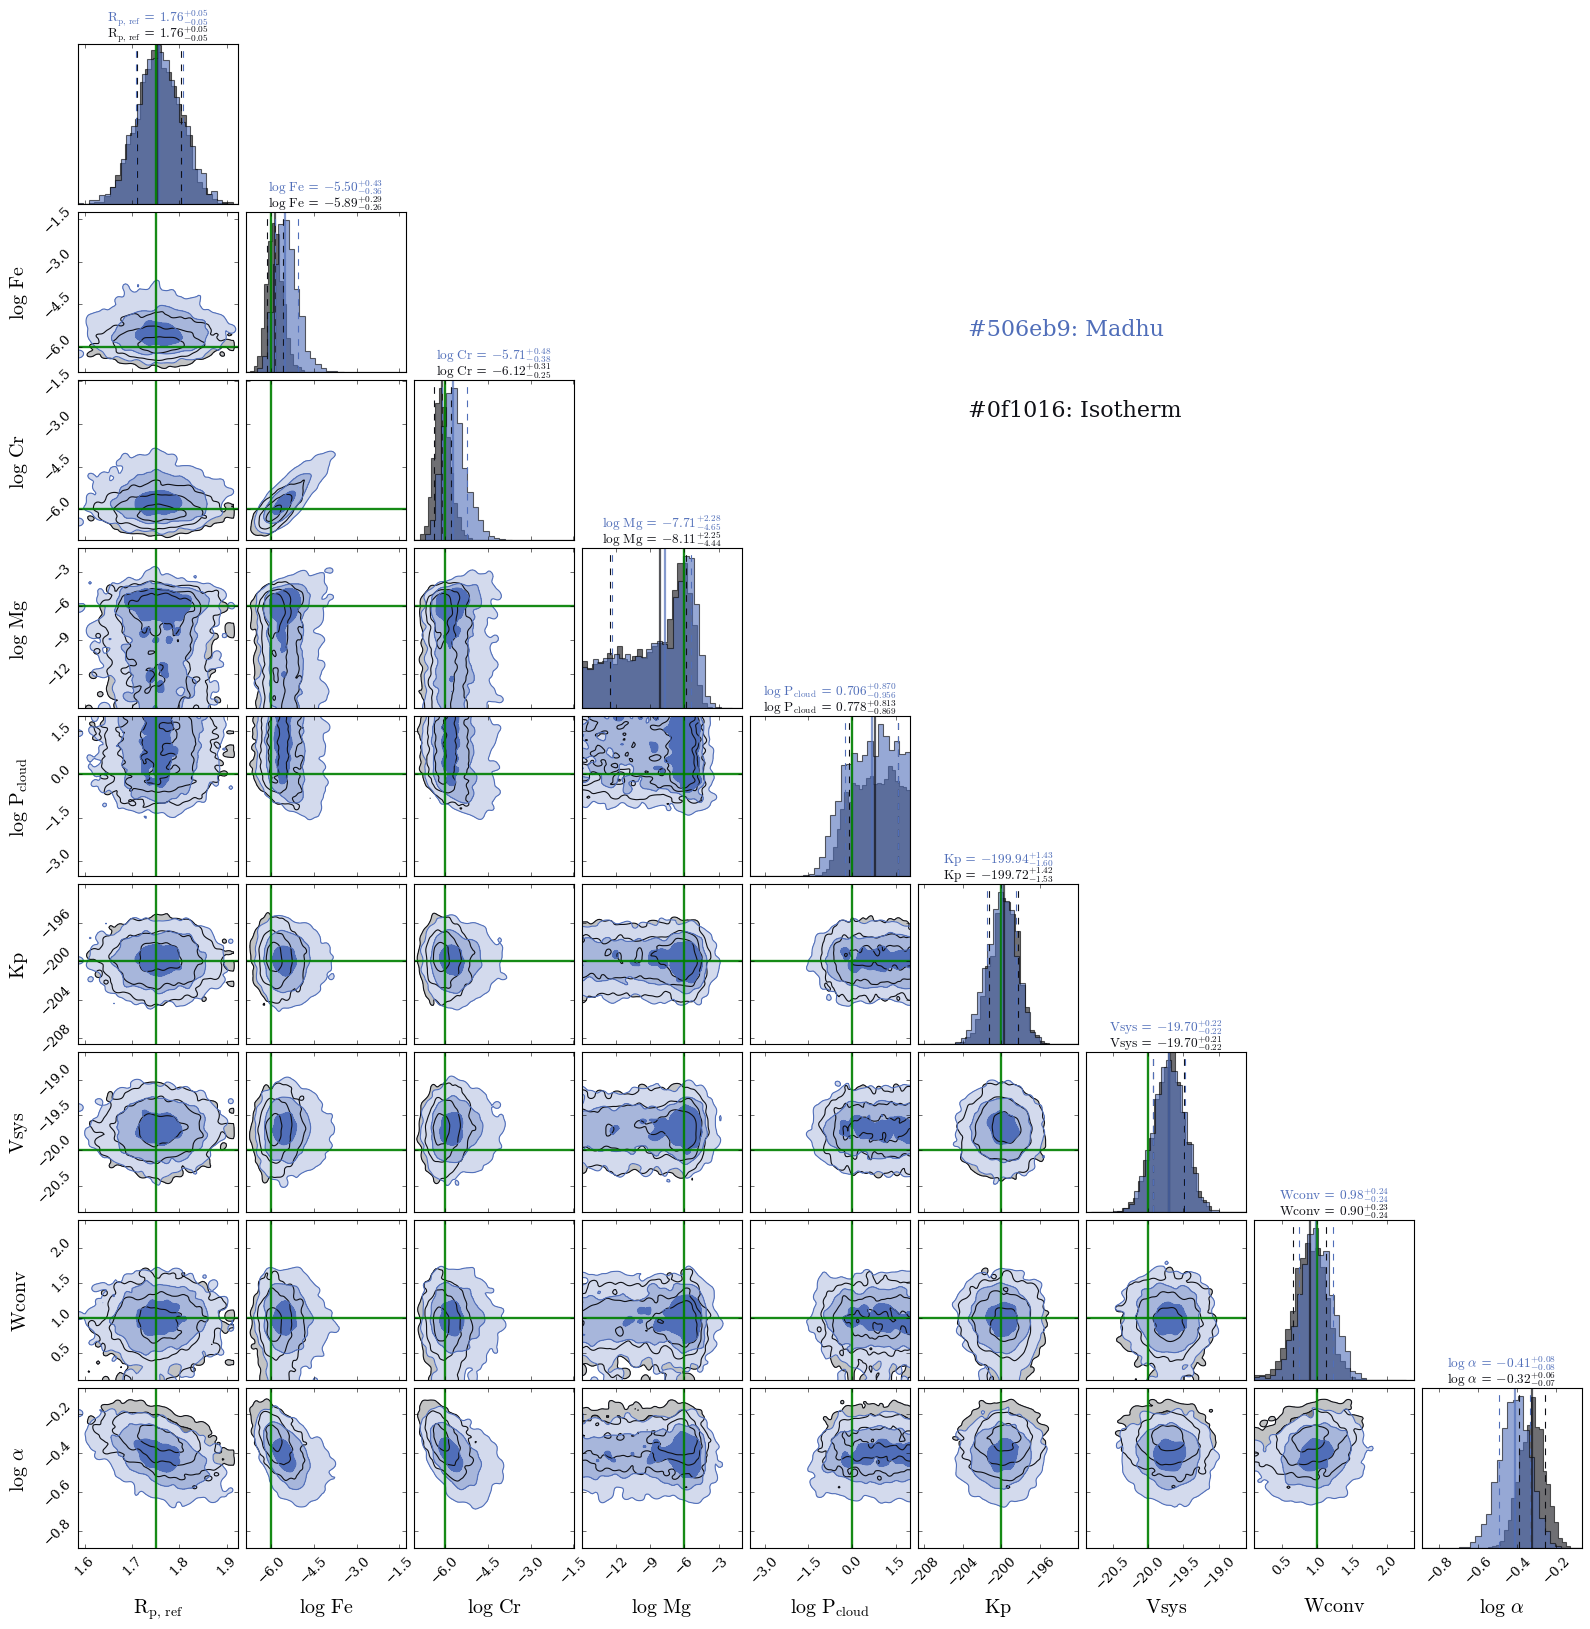

In [6]:
import colormaps as cmaps
import cmasher as cmr

sapphire = cmr.take_cmap_colors(
    "cmr.sapphire", 10, cmap_range=(0.1, 0.9), return_fmt="hex"
)

ember = cmr.take_cmap_colors("cmr.ember", 10, cmap_range=(0.1, 0.9), return_fmt="hex")

from POSEIDON.corner import generate_cornerplot, generate_overplot
import matplotlib.pyplot as plt

params_to_plot = [
    "R_p_ref",
    # "T",
    "log_Fe",
    "log_Cr",
    "log_Mg",
    "log_P_cloud",
    "K_p",
    "V_sys",
    "W_conv",
    "log_alpha",
]
fig = generate_overplot(
    planet,
    [model_2, model_1],
    params_to_plot=params_to_plot,
    model_display_names=["Isotherm", "Madhu"],
    true_vals=[1.75, -6, -6, -6, 0, -200, -20, 1, 0],
    truth_colour="green",
    colour_schemes=[sapphire[0], sapphire[5]],
)

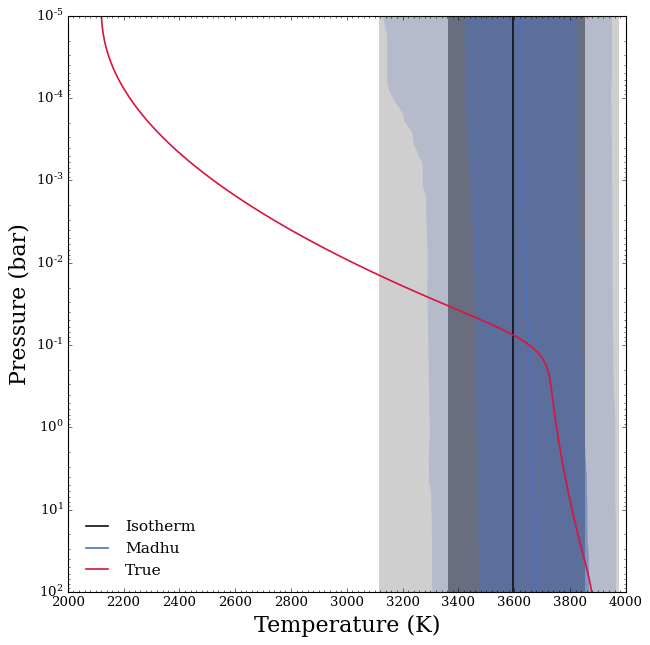

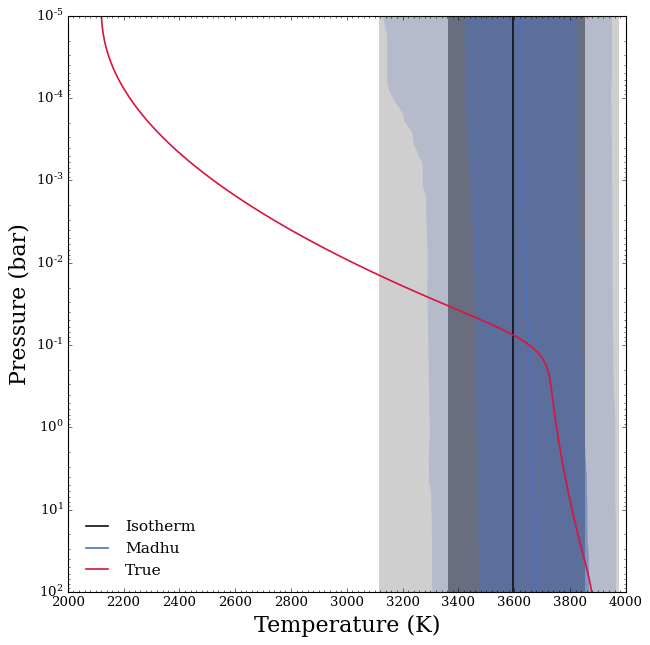

In [9]:
from POSEIDON.visuals import plot_PT_retrieved
from POSEIDON.utility import read_retrieved_PT, read_retrieved_log_X
from POSEIDON.core import make_atmosphere

params = (-6, -6, -6, 0.1, 0.3, -1, -2, 2, 3000)
log_Fe, log_Cr, log_Mg, a1, a2, log_P1, log_P2, log_P3, T_ref = params

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([a1, a2, log_P1, log_P2, log_P3, T_ref])
log_X_params = np.array([[log_Fe, log_Cr, log_Mg]])

P_min = 1e-5  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)
P_ref = 1e-2  # Reference pressure (bar)
# R_p_ref = R_p

atmosphere = make_atmosphere(
    planet,
    define_model(
        "Fe Cr Mg Madhu Injection Madhu",
        bulk_species,
        param_species,
        PT_profile="Madhu",
        high_res_params=high_res_params,
    ),
    P,
    P_ref,
    R_p,
    PT_params,
    log_X_params,
)

P, T_low2, T_low1, T_median, T_high1, T_high2 = read_retrieved_PT(
    planet_name, "Fe Cr Mg Madhu Injection", retrieval_name=None
)
PT_median = [(T_median, P)]
PT_low2 = [(T_low2, P)]
PT_low1 = [(T_low1, P)]
PT_high1 = [(T_high1, P)]
PT_high2 = [(T_high2, P)]

P, T_low2, T_low1, T_median, T_high1, T_high2 = read_retrieved_PT(
    planet_name, "Fe Cr Mg Madhu Injection Madhu", retrieval_name=None
)

PT_median += [(T_median, P)]
PT_low2 += [(T_low2, P)]
PT_low1 += [(T_low1, P)]
PT_high1 += [(T_high1, P)]
PT_high2 += [(T_high2, P)]

plot_PT_retrieved(
    planet_name,
    PT_median,
    PT_low2,
    PT_low1,
    PT_high1,
    PT_high2,
    T_true=atmosphere["T"].reshape(-1),
    Atmosphere_dimension=1,
    TwoD_type=None,
    plt_label=None,
    show_profiles=[],
    PT_labels=["Isotherm", "Madhu"],
    colour_list=[sapphire[0], sapphire[5]],
    log_P_min=-5,
    log_P_max=2,
    T_min=2000,
    T_max=4000,
    legend_location="lower left",
)

In [4]:
params_to_plot = ["R_p_ref", "log_H2O", "log_CO", "K_p", "V_sys", "a"]
fig = generate_cornerplot(
    planet,
    model_1,
    params_to_plot=params_to_plot,
    true_vals=[None, -4, -4, 192.6, -6.8, None],
)

Generating corner plot ...


ValueError: 'log_H2O' is not in list